## Loan Prediction

### About the problem

Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form.

### Load the data and clean

In [258]:
# Load required packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sb

In [259]:
# set working directory
dir = '/Users/fridah/Google Drive/Kaggle/K4-Loan'
os.chdir(dir)

In [260]:
# Import the test and train data
test = pd.read_csv(os.path.join(dir, 'data/train_u6lujuX_CVtuZ9i.csv'))
train = pd.read_csv(os.path.join(dir, 'data/test_Y3wMUE5_7gLdaTN.csv'))

In [261]:
# structure of the datasets
# train dataset
print(train.columns)
print(train.shape)

# test dataset
print(test.columns)
print(test.shape)

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')
(367, 12)
Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')
(614, 13)


In [262]:
# Append the dataset to create a final dataset that will be cleaned then separated again into test and train data
final = train.append(test)
print(final.columns)
print(final.shape)

# data types
final.dtypes

Index(['ApplicantIncome', 'CoapplicantIncome', 'Credit_History', 'Dependents',
       'Education', 'Gender', 'LoanAmount', 'Loan_Amount_Term', 'Loan_ID',
       'Loan_Status', 'Married', 'Property_Area', 'Self_Employed'],
      dtype='object')
(981, 13)


ApplicantIncome        int64
CoapplicantIncome    float64
Credit_History       float64
Dependents            object
Education             object
Gender                object
LoanAmount           float64
Loan_Amount_Term     float64
Loan_ID               object
Loan_Status           object
Married               object
Property_Area         object
Self_Employed         object
dtype: object

### Data cleaning
#### Convert variables into appropriate formats

In [263]:
# View the first 5 rows of the dataset 
final.head()

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Married,Property_Area,Self_Employed
0,5720,0.0,1.0,0,Graduate,Male,110.0,360.0,LP001015,NaN,Yes,Urban,No
1,3076,1500.0,1.0,1,Graduate,Male,126.0,360.0,LP001022,NaN,Yes,Urban,No
2,5000,1800.0,1.0,2,Graduate,Male,208.0,360.0,LP001031,NaN,Yes,Urban,No
3,2340,2546.0,NaN,2,Graduate,Male,100.0,360.0,LP001035,NaN,Yes,Urban,No
4,3276,0.0,1.0,0,Not Graduate,Male,78.0,360.0,LP001051,NaN,No,Urban,No


In [264]:
# Tabulate the character type variables
char_variables = list(final.select_dtypes(include=['object']).columns)
print(char_variables)

# tabulate the variable/unique values
for col in char_variables:
    print('Displaying results for: '+col)
    if len(final[col].unique())>=10:
        print(len(final[col].unique()))
    else:
        print(final[col].value_counts())

['Dependents', 'Education', 'Gender', 'Loan_ID', 'Loan_Status', 'Married', 'Property_Area', 'Self_Employed']
Displaying results for: Dependents
0     545
1     160
2     160
3+     91
Name: Dependents, dtype: int64
Displaying results for: Education
Graduate        763
Not Graduate    218
Name: Education, dtype: int64
Displaying results for: Gender
Male      775
Female    182
Name: Gender, dtype: int64
Displaying results for: Loan_ID
981
Displaying results for: Loan_Status
Y    422
N    192
Name: Loan_Status, dtype: int64
Displaying results for: Married
Yes    631
No     347
Name: Married, dtype: int64
Displaying results for: Property_Area
Semiurban    349
Urban        342
Rural        290
Name: Property_Area, dtype: int64
Displaying results for: Self_Employed
No     807
Yes    119
Name: Self_Employed, dtype: int64


In [265]:
# Convert the character variables to categorical
from pandas.api.types import CategoricalDtype

# 1. Dependents
final['Dependents'] = final['Dependents'].astype(CategoricalDtype(categories=['0','1','2','3+'],ordered=True))

# 2. Education
final['Education'] = final['Education'].astype(CategoricalDtype(categories=['Not Graduate','Graduate'],ordered=True))
    
# 3. Gender
final['Gender'] = final['Gender'].astype(CategoricalDtype(categories=['Male','Female'],ordered=False))

# 4. Married
final['Married'] = final['Married'].astype(CategoricalDtype(categories=['No','Yes'],ordered=True))
    
# 5. Property_Area
final['Property_Area'] = final['Property_Area'].astype(CategoricalDtype(categories=['Rural','Semiurban', 'Urban'],ordered=True))
    
# 6. Self_Employed
final['Self_Employed'] = final['Self_Employed'].astype(CategoricalDtype(categories=['No','Yes'],ordered=True))

# list of columns and their type
final.dtypes

ApplicantIncome         int64
CoapplicantIncome     float64
Credit_History        float64
Dependents           category
Education            category
Gender               category
LoanAmount            float64
Loan_Amount_Term      float64
Loan_ID                object
Loan_Status            object
Married              category
Property_Area        category
Self_Employed        category
dtype: object

#### Check and impute missing values

In [266]:
# Display the number of missing rows in each variable
miss = final.isnull().sum()
print(miss)

ApplicantIncome        0
CoapplicantIncome      0
Credit_History        79
Dependents            25
Education              0
Gender                24
LoanAmount            27
Loan_Amount_Term      20
Loan_ID                0
Loan_Status          367
Married                3
Property_Area          0
Self_Employed         55
dtype: int64


In [267]:
# create a list of variables that have missing values
miss_vars = list(miss.index[miss>0])

# drop Loan_Status from the list
miss_vars.remove('Loan_Status')

# for categorical variables - replace with the mode
cat_vars = list(final[miss_vars].select_dtypes(include=['category']).columns)
final[cat_vars] = final[cat_vars].apply(lambda x:x.fillna(x.value_counts().index[0]))

# for numerical variables - replace with the median
num_vars = list(final[miss_vars].select_dtypes(include=['int', 'float']).columns)
final[num_vars] = final[num_vars].apply(lambda x:x.fillna(x.median()))

# check if we still have missing values
print(final.isnull().sum())

ApplicantIncome        0
CoapplicantIncome      0
Credit_History         0
Dependents             0
Education              0
Gender                 0
LoanAmount             0
Loan_Amount_Term       0
Loan_ID                0
Loan_Status          367
Married                0
Property_Area          0
Self_Employed          0
dtype: int64


### Visualize the dataset

First let's separate the test and the train datasets for putposes of plotting.

In [268]:
train = final.loc[final['Loan_Status'].notnull(), :]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 13 columns):
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
Credit_History       614 non-null float64
Dependents           614 non-null category
Education            614 non-null category
Gender               614 non-null category
LoanAmount           614 non-null float64
Loan_Amount_Term     614 non-null float64
Loan_ID              614 non-null object
Loan_Status          614 non-null object
Married              614 non-null category
Property_Area        614 non-null category
Self_Employed        614 non-null category
dtypes: category(6), float64(4), int64(1), object(2)
memory usage: 42.6+ KB


Summary statistics by Loan Status

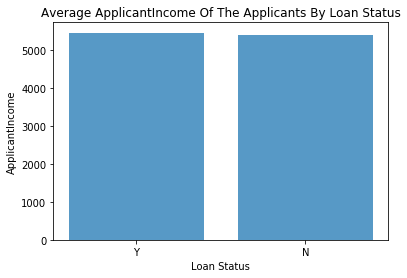

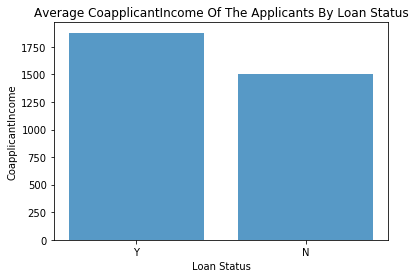

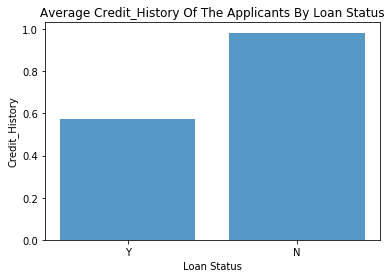

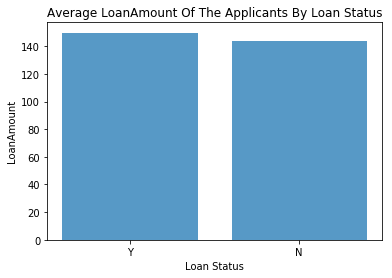

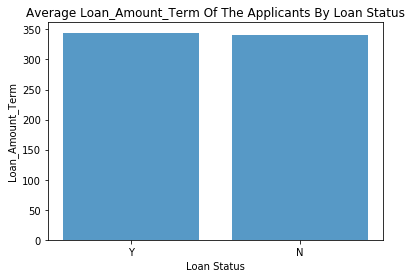

<Figure size 432x288 with 0 Axes>

In [269]:
# list of numeric variables
num_vars = train.select_dtypes(include = ['int','float']).columns

for col in num_vars:
    # Average income income by Loan Status
    sum_tab = final.groupby(['Loan_Status'])[col].mean()

    # prepare plot parameters
    loan_status = set(sum_tab.index)
    loan_pos = np.arange(len(loan_status))
    avg = list(sum_tab)

    # do the plot
    plt.bar(loan_pos, avg, align = 'center', alpha = 0.75)
    plt.xticks(loan_pos, loan_status)
    plt.ylabel(col)
    plt.xlabel('Loan Status')
    plt.title('Average '+col+' Of The Applicants By Loan Status')

    # display the plot
    plt.show()
    
    # save the plot
    plt.savefig(dir+'/output/'+col+'.png', transparent = True)

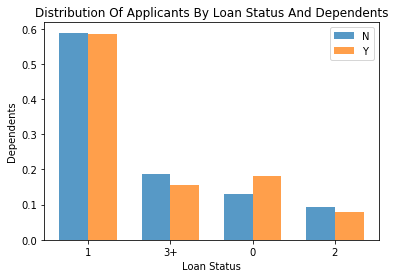

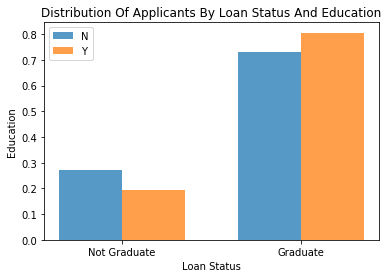

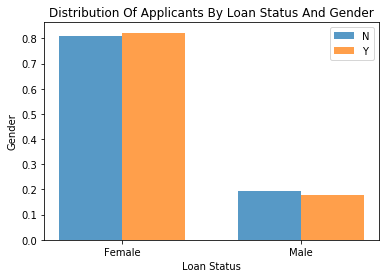

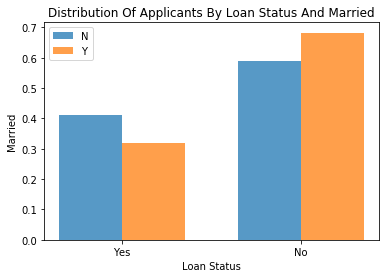

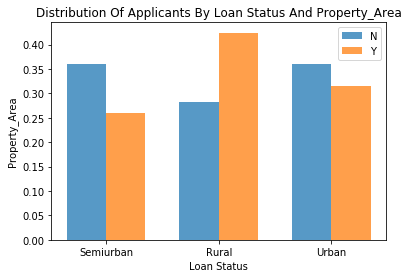

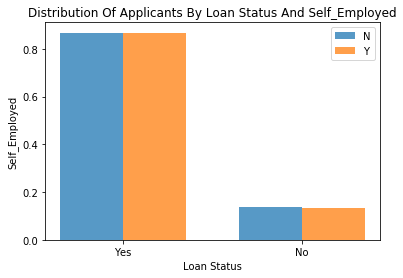

<Figure size 432x288 with 0 Axes>

In [270]:
# list of categorical variables
cat_vars = list(train.select_dtypes(include = ['category']).columns)

for col in cat_vars:
    # two-way frequencies of Loan status vs each of the categorical variables
    tabs = pd.crosstab(train['Loan_Status'],train[col], normalize = 'index')

    # prepare plot parameters
    levels = set(tabs.columns)
    loan_pos = np.arange(tabs.shape[1])
    percN = list(tabs.iloc[0, :])
    percY = list(tabs.iloc[1, :])
    bar_width = 0.35

    # do the plot
    P1 = plt.bar(loan_pos, percN, alpha = 0.75, label = "N", width = bar_width)
    P2 = plt.bar(loan_pos+bar_width, percY, alpha = 0.75, label = "Y", width = bar_width)

    plt.xticks(loan_pos+bar_width/2, levels)
    plt.ylabel(col)
    plt.xlabel('Loan Status')
    plt.title('Distribution Of Applicants By Loan Status And '+col)
    plt.legend()

    # display the plot
    plt.show()
        
    # save the plot
    plt.savefig(dir+'/output/'+col+'.png', transparent = True)

In [271]:
# Since all the categorical variables are ordinal in nature - we will convert them into numbers using sklearn's LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Create an instance of the encoder
lb = LabelEncoder()

# Conduct the encoding - except Loan_Status
for col in cat_vars:
    final[col] = lb.fit_transform(final[col])

# View the first 10 observations of the datasets
final.head(5)

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Married,Property_Area,Self_Employed
0,5720,0.0,1.0,0,0,1,110.0,360.0,LP001015,NaN,1,2,0
1,3076,1500.0,1.0,1,0,1,126.0,360.0,LP001022,NaN,1,2,0
2,5000,1800.0,1.0,2,0,1,208.0,360.0,LP001031,NaN,1,2,0
3,2340,2546.0,1.0,2,0,1,100.0,360.0,LP001035,NaN,1,2,0
4,3276,0.0,1.0,0,1,1,78.0,360.0,LP001051,NaN,0,2,0


In [272]:
# separate the test and train datasets
test = final.loc[final['Loan_Status'].isnull(), :]
print(test.shape)

train = final.loc[final['Loan_Status'].notnull(), :]
print(train.shape)

# Convert Loan status to numeric Loan_Status - replace Y with 1 and N with 0
train["Loan_Status"] = np.where(train["Loan_Status"].str.contains("Y"), 1, 0)
print(train['Loan_Status'].value_counts())

# View the first 10 observations of the datasets
train.head(5)

(367, 13)
(614, 13)
1    422
0    192
Name: Loan_Status, dtype: int64


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Married,Property_Area,Self_Employed
0,5849,0.0,1.0,0,0,1,126.0,360.0,LP001002,1,0,2,0
1,4583,1508.0,1.0,1,0,1,128.0,360.0,LP001003,0,1,0,0
2,3000,0.0,1.0,0,0,1,66.0,360.0,LP001005,1,1,2,1
3,2583,2358.0,1.0,0,1,1,120.0,360.0,LP001006,1,1,2,0
4,6000,0.0,1.0,0,0,1,141.0,360.0,LP001008,1,0,2,0


## Modelling
### Fit a logistic regression model
Here we want to assess the relationship between the different attributes of the applicant and whether the applicant qualified for the loan.

In [273]:
# create dataset with response only
y_df = train.loc[:, 'Loan_Status']

# create datasets with predictors only
x_df = train.copy()
try:
    x_df.drop(['Loan_Status', 'Loan_ID'],  inplace=True, axis = 1)
except ValueError:
    print("The column 'Loan_Status' has already been dropped.")


#### Split data into train and test

In [274]:
# import the model_selection class from the sklearn library
from sklearn.model_selection import train_test_split

# create train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.25, random_state=123)

# size of the train and test datasets
print(x_train.shape[0])
print(x_test.shape[0])

460
154


#### Train the model using the logisitc regression algorithm

In [275]:
# import the LogisticRegression class
from sklearn.linear_model import LogisticRegression

# create an instance of the logistic model
logistic = LogisticRegression()

# fit the logistic regerssion model
logistic.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Use the model to predict the Loan Status of the test dataset

In [276]:
# Predict
pred = logistic.predict(x_test)

# Model Accuracy
acc = logistic.score(x_test, y_test)
print(acc)

0.7727272727272727


### Train on train data from the competition and prepare dataset for submission

#### Create separate datasets for the predictors and response

In [277]:
# create dataset with response only
y_df = train.loc[:, 'Loan_Status']

# create datasets with predictors only
x_df = train.copy()
try:
    x_df.drop(['Loan_Status', 'Loan_ID'],  inplace=True, axis = 1)
except ValueError:
    print("The column 'Loan_Status' has already been dropped.")
    
# Train the model
# import the LogisticRegression class
from sklearn.linear_model import LogisticRegression

# create an instance of the logistic model
logistic = LogisticRegression()

# fit the logistic regerssion model
logistic.fit(x_df, y_df)

# Predict
x_test = test.copy()
x_test.drop(['Loan_Status', 'Loan_ID'],  inplace=True, axis = 1)
x_test['Loan_Status'] = logistic.predict(x_test)

# prepare dataset for submission
x_test["Loan_Status"] = np.where(x_test["Loan_Status"] == 1, "Y", "N")

# add Loan ID to the dataset
submission = pd.concat([test['Loan_ID'], x_test['Loan_Status']], axis=1)
submission.head(5)

# Export the submission file
submission.to_csv(dir+'/output/submission.csv', index=False)

### Fit a gradient boosted algorithm